<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 1</h1>


## Correlation of Future Orientation Index and Gross Domestic Product

### Tasks

In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

You will do the following tasks:
1. Aquire World Bank Data
2. Calculate the Future Orientation Index in Google Trends
3. Test the correlation between GDP and FOI

### Install requirements

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`wbgapi`](https://github.com/tgherzog/wbgapi) is a Python package which provides modern, pythonic access to the World Bank's data API. [Here](https://github.com/tgherzog/wbgapi) is the documentation of `wbgapi`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`scipy`](https://scipy.org/) is a Python package with different algorithms for scientific computing. [Here](https://docs.scipy.org/doc/scipy/reference/index.html#scipy-api) is the documentation of `scipy`.

In [ ]:
! pip install wbgapi
! pip install pandas
! pip install matplotlib
! pip install scipy

### Exercise 1: World Bank Data 
#### 1.1 Download WDI data

From the WDI we need three indicators:
* Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, `"NY.GDP.PCAP.PP.KD"`)
* The amount of Internet users (per 100 people, `"IT.NET.USER.ZS"`
* The total population (described as as "Population, Total", `"SP.POP.TOTL"`)

In the following code chunk, download all data (including extras) for all countries in year 2014 and save it as a pandas data frame. See [here](https://github.com/tgherzog/wbgapi#accessing-data) how to use the `data` subpackage of `wbgapi`.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use `skipAggs=True`.

In [1]:
import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
WDIdf = wb.data.DataFrame(['NY.GDP.PCAP.PP.KD', 'SP.POP.TOTL', 'IT.NET.USER.ZS'],
             labels = True,time=2014, skipAggs=True)

Now drop any row that has `NaN` for this you can use `pandas` [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method.

In [3]:
WDIdf = WDIdf.dropna()
WDIdf

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
ZWE,Zimbabwe,16.36474,2316.954536,13855753.0
ZMB,Zambia,6.50000,3375.941270,15737793.0
PSE,West Bank and Gaza,53.67000,5967.073437,4173398.0
VNM,Viet Nam,41.00000,7641.909428,91235504.0
VUT,Vanuatu,18.80000,2917.677875,269927.0
...,...,...,...,...
ATG,Antigua and Barbuda,67.78000,20451.218969,89236.0
AGO,Angola,21.40000,8183.164577,27128337.0
DZA,Algeria,29.50000,11561.259795,38760168.0


Next only keep rows where there are at least 5 Million internet users. Keep in Mind that the Internet Users are per 100 people, so don't forget to take the population into account.

For example in the dataset Austria has 80.995825 internet users per 100 people, while 8546356 people living in Austria. This means Austria has 6922191.55 internet users in total. The calculation for that is as follows:
<br>

$$
\begin{align}
internet\_users = population \cdot \frac{internet\_user\_per\_100}{100}
\end{align}
$$


In [4]:
mask = ( WDIdf['IT.NET.USER.ZS'] / 100 ) * WDIdf['SP.POP.TOTL'] > 5_000_000
WDIdf = WDIdf.loc[mask]

In [5]:
WDIdf

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
VNM,Viet Nam,41.000000,7641.909428,91235504.0
UZB,Uzbekistan,35.500000,6075.192224,30757700.0
USA,United States,73.000000,57301.600424,318386329.0
GBR,United Kingdom,91.610000,44026.528012,64602298.0
ARE,United Arab Emirates,90.400000,64334.091552,8835951.0
...,...,...,...,...
AUT,Austria,80.995825,52932.900112,8546356.0
AUS,Australia,84.000000,47193.171630,23475686.0
ARG,Argentina,64.700000,23550.099060,42669500.0


### Exercise 2: The Future Orientation Index in Google Trends 
#### 2.1 Download data from Google Trends

You can download the data from Google Trends following these steps:

1) Log out from your google account or set its language to English

2) Go to trends.google.com and search for 2013 

3) Add 2015 as a search term

4) Select custom time rage: full year: 2014

5) Set the region to “Worldwide”. You can also try with this link (it links to the google trends page with all settings from above applied): https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015

6) Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”

7) On the top right menu click the download button to get a geoMap.csv file

Load the .csv file in a pandas data frame. Notice in the file the first 3 Lines are actually only information (while the third is the header). You can skip these lines by using `skiprows=3` in `pd.read_csv`. Set the headers to `"Country", "G2013", "G2015"`, this can be done by the keyword argument `names` in `pd.read_csv`.

Now remove again all rows containing `NaN`.

All the percentage data is saved as a string containing the `%` symbol. You can remove this with `pandas` [`str.replace`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html) method and save them as integer with `pandas` [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) method. Do this for column `G2013` and `G2015`.

In [13]:
df_google = pd.read_csv('geoMap.csv', skiprows=3, names=['Country', 'G2013', 'G2015'])
df_google = df_google.dropna()

In [15]:
df_google['G2013'] = df_google['G2013'].str.replace('%', '').astype(int)
df_google['G2015'] = df_google['G2015'].str.replace('%', '').astype(int)
df_google['G2015']

2      35
3      13
4      38
5      15
6      16
       ..
233    42
234    29
235    38
236    35
237    46
Name: G2015, Length: 236, dtype: int32

#### 2.2 Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [16]:
df_google['FOI'] = df_google['G2015'] / df_google['G2013']

#### 2.3 Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country. For this you can use `pandas` [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method.

In [17]:
df = pd.merge(WDIdf, df_google, on='Country')
df

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,G2013,G2015,FOI
0,Uzbekistan,35.500000,6075.192224,3.075770e+07,73,27,0.369863
1,United States,73.000000,57301.600424,3.183863e+08,58,42,0.724138
2,United Kingdom,91.610000,44026.528012,6.460230e+07,52,48,0.923077
3,United Arab Emirates,90.400000,64334.091552,8.835951e+06,66,34,0.515152
4,Ukraine,46.235975,12385.813477,4.527216e+07,79,21,0.265823
5,Tunisia,46.160000,10767.222909,1.142895e+07,74,26,0.351351
6,Thailand,34.890000,15509.181101,6.996094e+07,73,27,0.369863
7,Switzerland,87.400000,66930.868627,8.188649e+06,50,50,1.000000
8,Sweden,92.520000,49258.996164,9.696110e+06,60,40,0.666667
9,Spain,76.190000,35983.807571,4.648088e+07,63,37,0.587302


### Exercise: 3 Testing the correlation between GDP and FOI 
#### 3.1 Visualize FOI vs GDP

Now that you have the FOI index, GPD per capita and PPP value for each country, you can make a scatter plot of FOI vs GDP.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

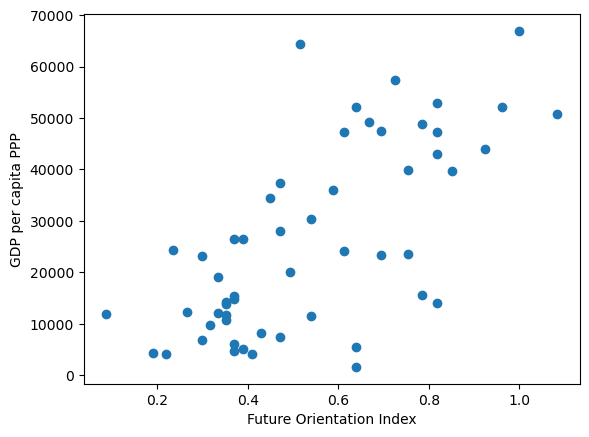

In [18]:
plt.scatter(df['FOI'], df['NY.GDP.PCAP.PP.KD'])

plt.xlabel("Future Orientation Index")
plt.ylabel("GDP per capita PPP");

#### 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [19]:
corr, p_val = stats.pearsonr(df['NY.GDP.PCAP.PP.KD'], df['FOI'])

print('Correlation: \033[1m{:.3f}\033[0m'.format(corr))

Correlation: 0.681


### To learn more
#### Check robustness
* What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
* How do results change if you use a different threshod instead of 5 Million Internet users?
    
#### Test other hypotheses
* Is future orientation generating wealth? Or is wealth enabling to look more to the future?
* Is the FOI really measuring orientation to the future? Could it be something else?

### Pytrends Module
* Use the [pytrends module](https://pypi.org/project/pytrends/) to get weekly Google Trends data concerning the [Flu/Influenza](https://en.wikipedia.org/wiki/Influenza) virus from the beginning of 2014 until the end of 2018.
* Create an instance of the `TrendReq` class
* Find the appropriate query term. The TrendReq class includes a method `suggestions`, which should help you in this task (the query term can look like e.g. `/m/03x_m3v`).
* Specify the correct geographical region, the timeframe, and the key-word list. Use the `build_payload` method to store this information for future requests.
* Use the `interest_over_time` method to get the data.